# Look at Affects of Noise

Here we will look at different affects of noise.



In [53]:
import numpy as np
from mth5.data.make_mth5_from_asc import create_test12rr_h5
from mth5.data.paths import SyntheticTestPaths
from mth5.mth5 import MTH5

from mtpy.processing import AuroraProcessing


In [54]:
synthetic_test_paths = SyntheticTestPaths()
target_folder = synthetic_test_paths.mth5_path
mth5_path = target_folder.joinpath("test12rr.h5")
if not mth5_path.exists():
    create_test12rr_h5(target_folder=target_folder)  



2024-10-16T15:53:38.010396-0700 | INFO | mth5.mth5 | _initialize_file | Initialized MTH5 0.1.0 file C:\Users\jpeacock\OneDrive - DOI\Documents\GitHub\mth5\mth5\data\mth5\test12rr.h5 in mode w
2024-10-16T15:53:40.919937-0700 | INFO | mth5.mth5 | close_mth5 | Flushing and closing C:\Users\jpeacock\OneDrive - DOI\Documents\GitHub\mth5\mth5\data\mth5\test12rr.h5


## Add AC Noise

Since the data is sampled at 1 second, we will add a 12 second sinusoid to the data.



In [118]:
def get_ac_noise(time, amplitude, period):
    return amplitude * np.sin(2 * np.pi * (1 / period) * time)

In [120]:

def get_impulses(time, max_amp, n_impulses=50):
    imp = np.zeros_like(time)
    for ii in range(n_impulses):
        index = np.random.randint(0, imp.size)
        amplitude = (-1)**(np.random.randint(0, 9))*np.random.randint(1, max_amp)
        imp[index] = amplitude
    return imp

In [121]:
def get_periodic_noise_electric(time, period=4, repeat=16, max_amplitude=8000):
    comb = np.zeros_like(time)
    for ii in np.linspace(0, comb.size-(period + 1), repeat):
        comb[int(ii): int(ii)+period] = 1 * max_amplitude
    return comb 

In [122]:
def get_periodic_noise_magnetic(time, period=4, repeat=16, max_amplitude=8000):
    comb = np.zeros_like(time)
    for ii in np.linspace(0, comb.size-(period + 1), repeat):
        comb[int(ii)] = 1 * max_amplitude
        comb[int(ii)+period] = -1 * max_amplitude

    response = max_amplitude * np.exp(np.arange(period)**2 / repeat)
    comb = np.convolve(comb, response, mode="same")
    return comb 

In [123]:
with MTH5() as m:
    m = m.open_mth5(mth5_path)
    runts = m.get_run("test1", "001").to_runts()
    t = np.arange(len(runts.dataset.time))

    # add AC noise
    new_run = runts.copy()
    new_run.run_metadata.id = "12s_sinusoid"
    for channel in new_run.channels:
        ch = getattr(new_run, channel)
        ac_noise = get_ac_noise(t, 2*ch.ts.max(), 12)
        ch.ts = ch.ts + ac_noise
        setattr(new_run, channel, ch)
    rg = m.add_run("test1", new_run.run_metadata.id)
    rg.from_runts(new_run)

    # add impulse noise
    new_run = runts.copy()
    new_run.run_metadata.id = "impulses"
    for channel in new_run.channels:
        ch = getattr(new_run, channel)
        impulse_noise = get_impulses(t, 2*ch.ts.max(), 100)
        ch.ts = ch.ts + impulse_noise
        setattr(new_run, channel, ch)
    rg = m.add_run("test1", new_run.run_metadata.id)
    rg.from_runts(new_run)

    # add periodic noise
    new_run = runts.copy()
    new_run.run_metadata.id = "periodic"
    for channel in new_run.channels:
        ch = getattr(new_run, channel)
        if ch.component in ["ex", "ey"]:
            periodic_noise = get_periodic_noise_electric(t, max_amplitude=1.5*ch.ts.max())
        elif ch.component in ["hx", "hy", "hz"]:
            periodic_noise = get_periodic_noise_magnetic(t, max_amplitude=1.5*ch.ts.max())
        ch.ts = ch.ts + periodic_noise
        setattr(new_run, channel, ch)
    rg = m.add_run("test1", new_run.run_metadata.id)
    rg.from_runts(new_run)


2024-10-16T16:52:00.491998-0700 | INFO | mth5.groups.base | _add_group | RunGroup 12s_sinusoid already exists, returning existing group.
2024-10-16T16:52:00.608780-0700 | WARNING | mth5.groups.run | from_runts | Channel run.id 001 !=  group run.id 12s_sinusoid. Setting to ch.run_metadata.id to 12s_sinusoid
2024-10-16T16:52:00.756731-0700 | WARNING | mth5.groups.run | from_runts | Channel run.id 001 !=  group run.id 12s_sinusoid. Setting to ch.run_metadata.id to 12s_sinusoid
2024-10-16T16:52:00.908992-0700 | WARNING | mth5.groups.run | from_runts | Channel run.id 001 !=  group run.id 12s_sinusoid. Setting to ch.run_metadata.id to 12s_sinusoid
2024-10-16T16:52:01.059198-0700 | WARNING | mth5.groups.run | from_runts | Channel run.id 001 !=  group run.id 12s_sinusoid. Setting to ch.run_metadata.id to 12s_sinusoid
2024-10-16T16:52:01.225856-0700 | WARNING | mth5.groups.run | from_runts | Channel run.id 001 !=  group run.id 12s_sinusoid. Setting to ch.run_metadata.id to 12s_sinusoid
2024-10-

### Plot Noisy Data

Lets plot the data and see what the spectral content now looks like.

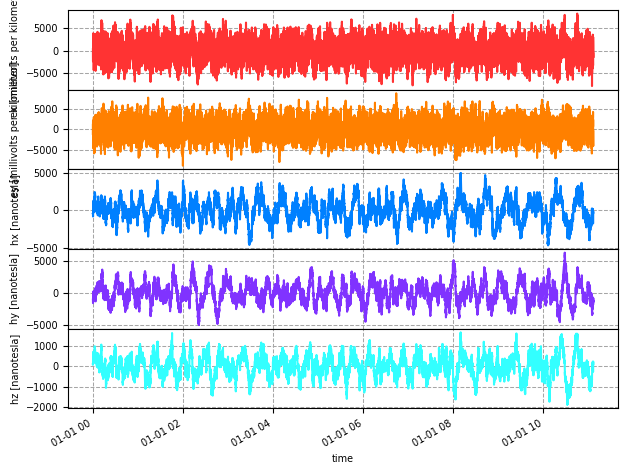

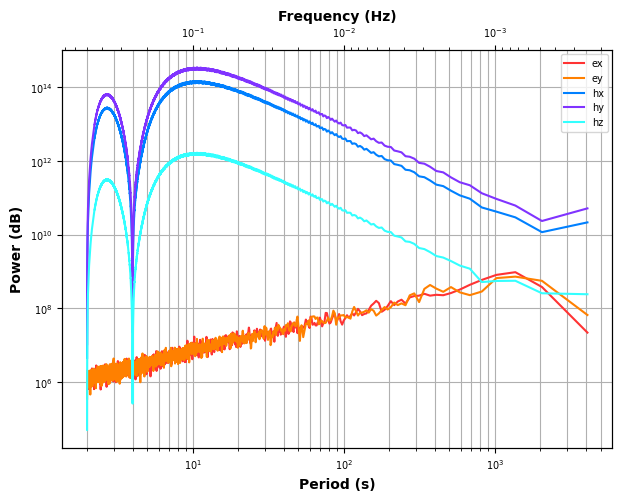

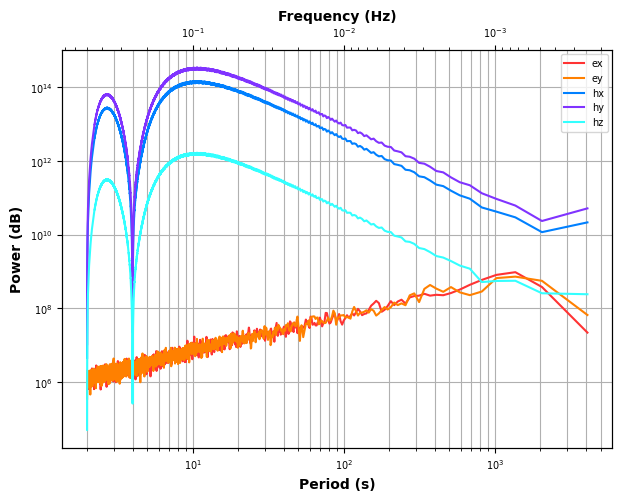

In [124]:
new_run.plot()
new_run.plot_spectra()

## Process with Aurora

Now that we've added noise lets see what it does to the MT response.

In [137]:
ap = AuroraProcessing()
ap.local_station_id = "test1"
ap.remote_station_id = None
ap.local_mth5_path = mth5_path
ap.remote_mth5_path = mth5_path

### Run Summary

We need to get just the runs that we want to process. Include the remote run.

In [138]:
run_summary = ap.get_run_summary()
run_summary.mini_summary

2024-10-16T16:57:19.861346-0700 | INFO | mth5.mth5 | close_mth5 | Flushing and closing C:\Users\jpeacock\OneDrive - DOI\Documents\GitHub\mth5\mth5\data\mth5\test12rr.h5


,survey,station,run,start,end,duration
0,EMTF Synthetic,test1,001,1980-01-01 00:00:00+00:00,1980-01-01 11:06:39+00:00,39999.0
1,EMTF Synthetic,test1,12s_sinusoid,1980-01-01 00:00:00+00:00,1980-01-01 11:06:39+00:00,39999.0
2,EMTF Synthetic,test1,impulses,1980-01-01 00:00:00+00:00,1980-01-01 11:06:39+00:00,39999.0
3,EMTF Synthetic,test1,periodic,1980-01-01 00:00:00+00:00,1980-01-01 11:06:39+00:00,39999.0
4,EMTF Synthetic,test2,001,1980-01-01 00:00:00+00:00,1980-01-01 11:06:39+00:00,39999.0


Here pick the runs you want to process.  Should pick one of the noisy runs and then the remote. The index is the first column.

In [140]:
noise_run_summary = run_summary.clone()
noise_run_summary.df = noise_run_summary.df.iloc[[3, 4]]
noise_run_summary.mini_summary

,survey,station,run,start,end,duration
3,EMTF Synthetic,test1,periodic,1980-01-01 00:00:00+00:00,1980-01-01 11:06:39+00:00,39999.0
4,EMTF Synthetic,test2,001,1980-01-01 00:00:00+00:00,1980-01-01 11:06:39+00:00,39999.0


## Process Single Station

Now process the noise type picked and see how that noise affects the data and how the remote reference helps mitigate that noise. 

2024-10-16T16:57:38.269108-0700 | INFO | mtpy.processing.kernel_dataset | _add_columns | KernelDataset DataFrame needs column fc, adding and setting dtype to <class 'pandas._libs.missing.NAType'>.
2024-10-16T16:57:38.270833-0700 | INFO | mtpy.processing.kernel_dataset | _add_columns | KernelDataset DataFrame needs column remote, adding and setting dtype to <class 'bool'>.
2024-10-16T16:57:38.272425-0700 | INFO | mtpy.processing.kernel_dataset | _add_columns | KernelDataset DataFrame needs column run_dataarray, adding and setting dtype to <class 'NoneType'>.
2024-10-16T16:57:38.275141-0700 | INFO | mtpy.processing.kernel_dataset | _add_columns | KernelDataset DataFrame needs column stft, adding and setting dtype to <class 'NoneType'>.
2024-10-16T16:57:38.278160-0700 | INFO | mtpy.processing.kernel_dataset | _add_columns | KernelDataset DataFrame needs column mth5_obj, adding and setting dtype to <class 'NoneType'>.
2024-10-16T16:57:38.286698-0700 | INFO | aurora.config.config_creator | 

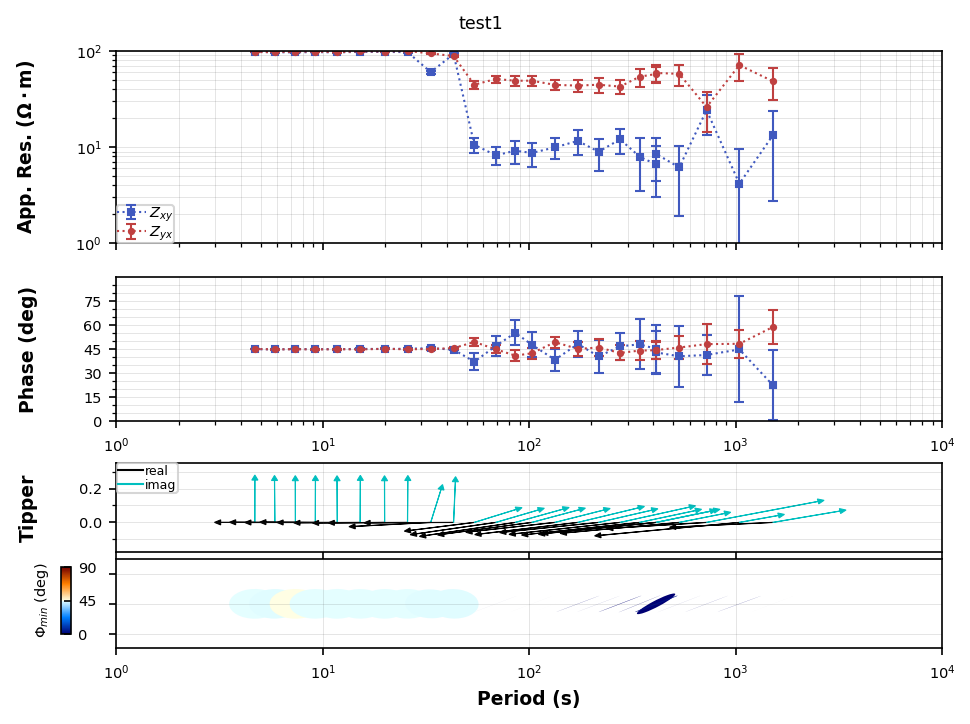

Plotting PlotMTResponse

In [141]:
kds = ap.create_kernel_dataset(run_summary=noise_run_summary, local_station_id="test1")
config = ap.create_config(kds)
mt_12s_noise = ap.process_single_sample_rate(1, config, kds)
mt_12s_noise.plot_mt_response()

## Remote Reference Processing

Now we can try to reduce the effect of local noise by using a remote reference.  In this case the remote helps only slightly because the time series is short and there aren't that many estimates.  If we had longer time series the remote would help more.  

There are other things you can do to the data. You could apply a notch filter at the frequency your noise is at if you are certain that it is a pure sinusoid.  

2024-10-16T16:58:27.771106-0700 | INFO | mtpy.processing.kernel_dataset | _add_columns | KernelDataset DataFrame needs column fc, adding and setting dtype to <class 'pandas._libs.missing.NAType'>.
2024-10-16T16:58:27.772105-0700 | INFO | mtpy.processing.kernel_dataset | _add_columns | KernelDataset DataFrame needs column remote, adding and setting dtype to <class 'bool'>.
2024-10-16T16:58:27.773104-0700 | INFO | mtpy.processing.kernel_dataset | _add_columns | KernelDataset DataFrame needs column run_dataarray, adding and setting dtype to <class 'NoneType'>.
2024-10-16T16:58:27.773104-0700 | INFO | mtpy.processing.kernel_dataset | _add_columns | KernelDataset DataFrame needs column stft, adding and setting dtype to <class 'NoneType'>.
2024-10-16T16:58:27.774808-0700 | INFO | mtpy.processing.kernel_dataset | _add_columns | KernelDataset DataFrame needs column mth5_obj, adding and setting dtype to <class 'NoneType'>.
2024-10-16T16:58:27.790966-0700 | INFO | aurora.config.config_creator | 

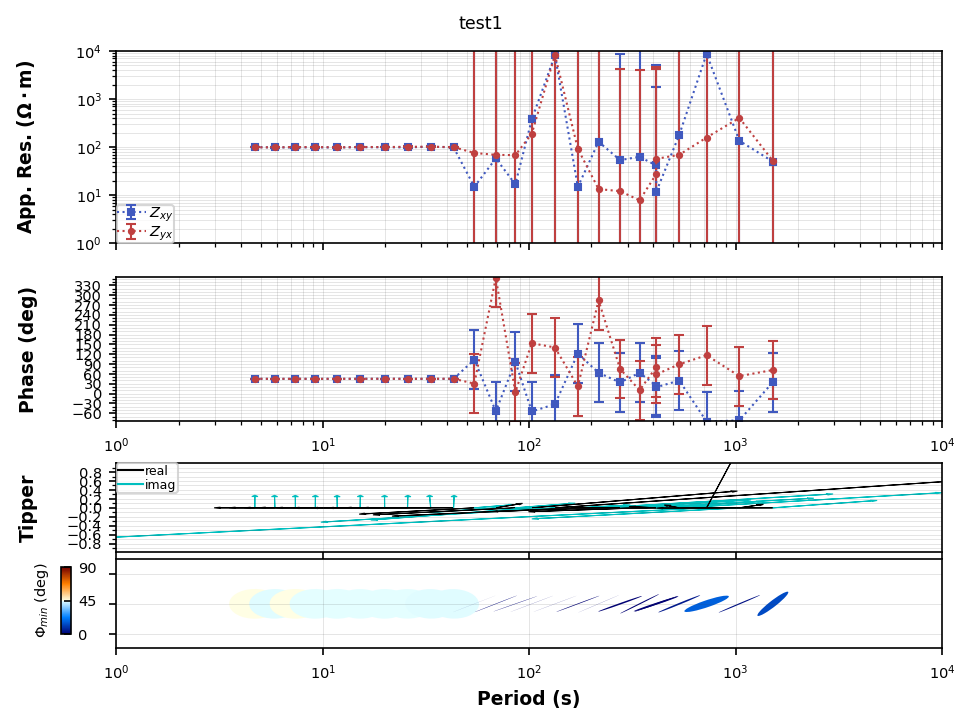

Plotting PlotMTResponse

In [143]:
kds = ap.create_kernel_dataset(
    run_summary=noise_run_summary, 
    local_station_id="test1",
    remote_station_id="test2"
    )
config = ap.create_config(kds)
mt_12s_noise_rr = ap.process_single_sample_rate(1, config, kds)
mt_12s_noise_rr.plot_mt_response()